In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from util import *
# import torch
# import torch.utils.data as Data
# from e2cnn import nn
# from e2cnn import gspaces

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [3]:
# Nhid=[512,256,128,64]
# e2cnn=CNDNN(Nhid,4,3,device).float()

In [4]:
paths=['/glade/u/home/adac/work/microHH/microhh2/cases/SBL1800_k64_dt1/','/glade/u/home/adac/work/microHH/microhh2/cases/SBL1800_k64_largePert/']
varStr=['u','v','w','b']

In [5]:
size = 1 # number of neighboring points to include in each input sample
#size = 3

xList_local = []
xList_global = []
xList_unscaled = []
yList_local = []
yList_global = []
yList_unscaled = []
scalesList = []

fileSplitInd = [0]
counter=0

itmin=0
itmax=0
for ifile in range(len(paths)): #tdqm notebook just draws progress bar
    path=paths[ifile]

    # open_mfdatset not working with this version of xarray for some reason, 
    # could install dask to fix error judging by error message
    uda=xr.open_dataset(path+varStr[0]+'.nc')[varStr[0]]
    vda=xr.open_dataset(path+varStr[1]+'.nc')[varStr[1]]
    wda=xr.open_dataset(path+varStr[2]+'.nc')[varStr[2]]
    bda=xr.open_dataset(path+varStr[3]+'.nc')[varStr[3]]
    
    # Getting grid vairables to comput grid size
    x=vda['x'].values
    y=uda['y'].values
    nbl=int(0.75*uda.shape[1])
    z=uda['z'].values[:nbl]
    dx=np.mean(np.diff(x))
    dy=np.mean(np.diff(y))
    dz=np.mean(np.diff(z))
  
    
    # Getting input variables, removing laminar layers, wrapping periodic varaibles as reordering to x,y,z,t 
    uwrap=uda[itmin:itmax+1,0:nbl].pad(xh=(1,0), mode='wrap')
    ucenter=0.5*(uwrap[:,:,:,1:].assign_coords(xh=vda['x'].values)+uwrap[:,:,:,:-1].assign_coords(xh=vda['x'].values))
    u=ucenter.pad({'xh':(size,size),'y':(size,size)},mode='wrap').transpose().values

    vwrap=vda[itmin:itmax+1,0:nbl].pad(yh=(1,0), mode='wrap')
    vcenter=0.5*(vwrap[:,:,1:,:].assign_coords(yh=uda['y'].values)+vwrap[:,:,:-1,:].assign_coords(yh=uda['y'].values))
    v=vcenter.pad({'x':(size,size),'yh':(size,size)},mode='wrap').transpose().values

    wpad=wda[:,0:nbl+1]
    wcenter=0.5*(wpad[itmin:itmax+1,1:,:,:].assign_coords(zh=z)+wpad[:,:-1,:,:].assign_coords(zh=z))
    w=wcenter.pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values

    b=bda[itmin:itmax+1,0:nbl].pad({'x':(size,size),'y':(size,size)},mode='wrap').transpose().values

    inputFields = np.array([u, v, w, b])

    # # Getting output fields
    # tau_12 = np.transpose(cut_laminar(ds['tau12'].values), [2, 1, 0,3])
    # tau_13 = np.transpose(cut_laminar(ds['tau13'].values), [2, 1, 0,3])
    # tau_23 = np.transpose(cut_laminar(ds['tau23'].values), [2, 1, 0,3])
    # tau_11 = np.transpose(cut_laminar(ds['tau11'].values), [2, 1, 0,3])
    # tau_22 = np.transpose(cut_laminar(ds['tau22'].values), [2, 1, 0,3])
    # tau_33 = np.transpose(cut_laminar(ds['tau33'].values), [2, 1, 0,3])
    # outputFields = np.array([tau_11,tau_12, tau_13, tau_22, tau_23, tau_33])

    
    #delta=(dx*dy*dz)**(1.0/3.0)

    # Computing gradients for scaling saling variables: TKE, TPE, and N2
    d11=(u[2:,1:-1,:,:]-u[:-2,1:-1,:,:])/(2*dx)
    d12=(u[1:-1,2:,:,:]-u[1:-1,:-2,:,:])/(2*dy)
    d13=np.gradient(u[1:-1,1:-1,:,:],dz,axis=2)

    d21=(v[2:,1:-1,:,:]-v[:-2,1:-1,:,:])/(2*dx)
    d22=(v[1:-1,2:,:,:]-v[1:-1,:-2,:,:])/(2*dy)
    d23=np.gradient(v[1:-1,1:-1,:,:],dz,axis=2)

    d31=(w[2:,1:-1,:,:]-w[:-2,1:-1,:,:])/(2*dx)
    d32=(w[1:-1,2:,:,:]-w[1:-1,:-2,:,:])/(2*dy)
    d33=np.gradient(w[1:-1,1:-1,:,:],dz,axis=2)
    
#     #dijdij = (d11*d11 + d12*d12 + d13*d13 + d21*d21 + d22*d22 + d23*d23 + d31*d31 + d32*d32 + d33*d33)
    
    # Copmute anisotropic local scaling factors
    TKE_h = dx**2*(d11**2 + d21**2) + dy**2*(d12**2 + d22**2) + dz**2*(d13**2 + d23**2) 
    TKE_v = dx**2*d31**2 + dy**2*d32**2 + dz**2*d33**2
    TKE = TKE_h + TKE_v
    #TKE = (delta**2/1.0)*dijdij
    del d11,d12,d13,d21,d22,d23,d31,d32,d33#,TKE_h

    db1=(b[2:,1:-1,:,:]-b[:-2,1:-1,:,:])/(2*dx)
    db2=(b[1:-1,2:,:,:]-b[1:-1,:-2,:,:])/(2*dy)
    db3=np.gradient(b[1:-1,1:-1,:,:],dz,axis=2)
    N2=db3
    
    #dbkdbk=db1*db1+db2*db2+db3*db3
    TPE=(dx**2*db1**2+dy**2*db2**2+dz**2*db3**2)/N2
    #TPE = (delta**2/1.0)*dbkdbk/N2
    del db1,db2,db3 
    gc.collect()

    hvelScale = np.pad(np.sqrt(TKE),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    vvelScale = np.pad(np.sqrt(TKE_v),((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    bScale = np.pad(TPE/dz,((size,size),(size,size),(0,0),(0,0)),mode='wrap')
    ti3Scale=np.sqrt(TKE*TKE_v)
    tijScale=np.array([TKE,TKE,ti3Scale,TKE,ti3Scale,TKE_v])

    for i in range(size, inputFields.shape[1] - size):
        for j in range(size, inputFields.shape[2] - size):
            for k in range(size, inputFields.shape[3] - size):
                for it in range(inputFields.shape[4]):
                    #if np.random.rand(1)<fileMaskPercents[ifile]:
                        ## No normalization
                        scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1),
                                     scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=1)]
                        xList_unscaled.append(scaledInput)                        
                        # yList_unscaled.append(outputFields[:,i-size,j-size,k,it])
                        
                        ## Local Scaling 
                        scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                     scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=hvelScale[i, j, k, it]),
                                     scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=vvelScale[i, j, k, it]),
                                     scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=bScale[i, j, k, it])]
                        xList_local.append(scaledInput)
                        scalesList.append([TKE[i-size,j-size,k,it],TKE_h[i-size,j-size,k,it],TKE_v[i-size,j-size,k,it],TPE[i-size,j-size,k,it]])
                        # yList_local.append(outputFields[:,i-size,j-size,k,it]/tijScale[:,i-size,j-size,k,it])

                        # ## Global Scaling
                        # scaledInput=[scale(inputFields[0,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[1,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[2,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileUgs[ifile]/np.sqrt(fileRes[ifile])),
                        #              scale(inputFields[3,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, it],sd=fileb0s[ifile])]
                        # xList_global.append(scaledInput)
                        # yList_global.append(outputFields[:,i-size,j-size,k,it]*fileRes[ifile]/fileUgs[ifile]**2)
                        
                        counter+=1
    
    fileSplitInd.append(counter)
                                         
xlocal=np.array(xList_local)
# xglobal=np.array(xList_global)
xunscaled=np.array(xList_unscaled)
ylocal=np.array(yList_local)
# yglobal=np.array(yList_global)
yunscaled=np.array(yList_unscaled)
scales=np.array(scalesList)

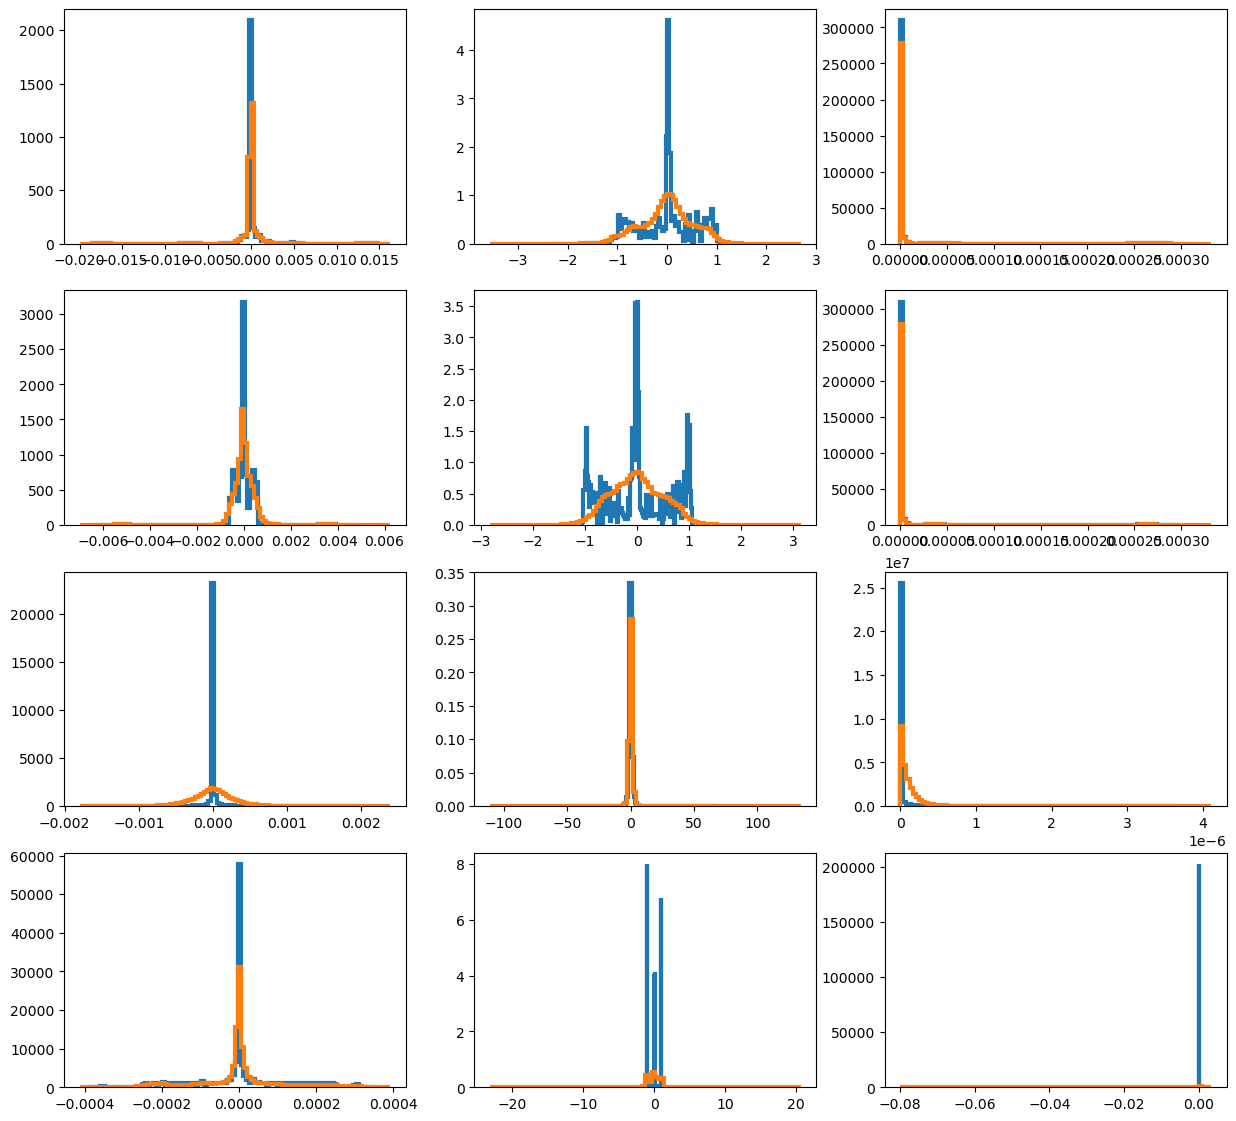

In [6]:
lw=3

fig1,ax1 = plt.subplots(4,3,figsize = (15,14))
varNames = [r'$\overline{u}$', r'$\overline{v}$', r'$\overline{w}$', r'$\overline{b}$']
scaleNames = [r'$k$', r'$k_h$', r'$k_v$', r'$e_p$']
fileNames = ['small pert','large pert']

bwfactor=1
bins=100
for ivar in range(len(varNames)):
    for ifile in range(len(paths)):
        
        #if ivar==3:
                #bwfactor=1#3*bwfactor

        # sns.kdeplot(ax=ax1[ivar,0],data=xunscaled[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bw_adjust=bwfactor)
        # sns.kdeplot(ax=ax1[ivar,1],   data=xlocal[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bw_adjust=bwfactor)
        # sns.kdeplot(ax=ax1[ivar,2],   data=scales[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bw_adjust=bwfactor)

        ax1[ivar,0].hist(xunscaled[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bins=bins,density=True,histtype='step')
        ax1[ivar,1].hist(xlocal[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bins=bins,density=True,histtype='step')
        ax1[ivar,2].hist(scales[fileSplitInd[ifile]:fileSplitInd[ifile+1],ivar].flatten(),label=fileNames[ifile],linewidth=lw,bins=bins,density=True,histtype='step')

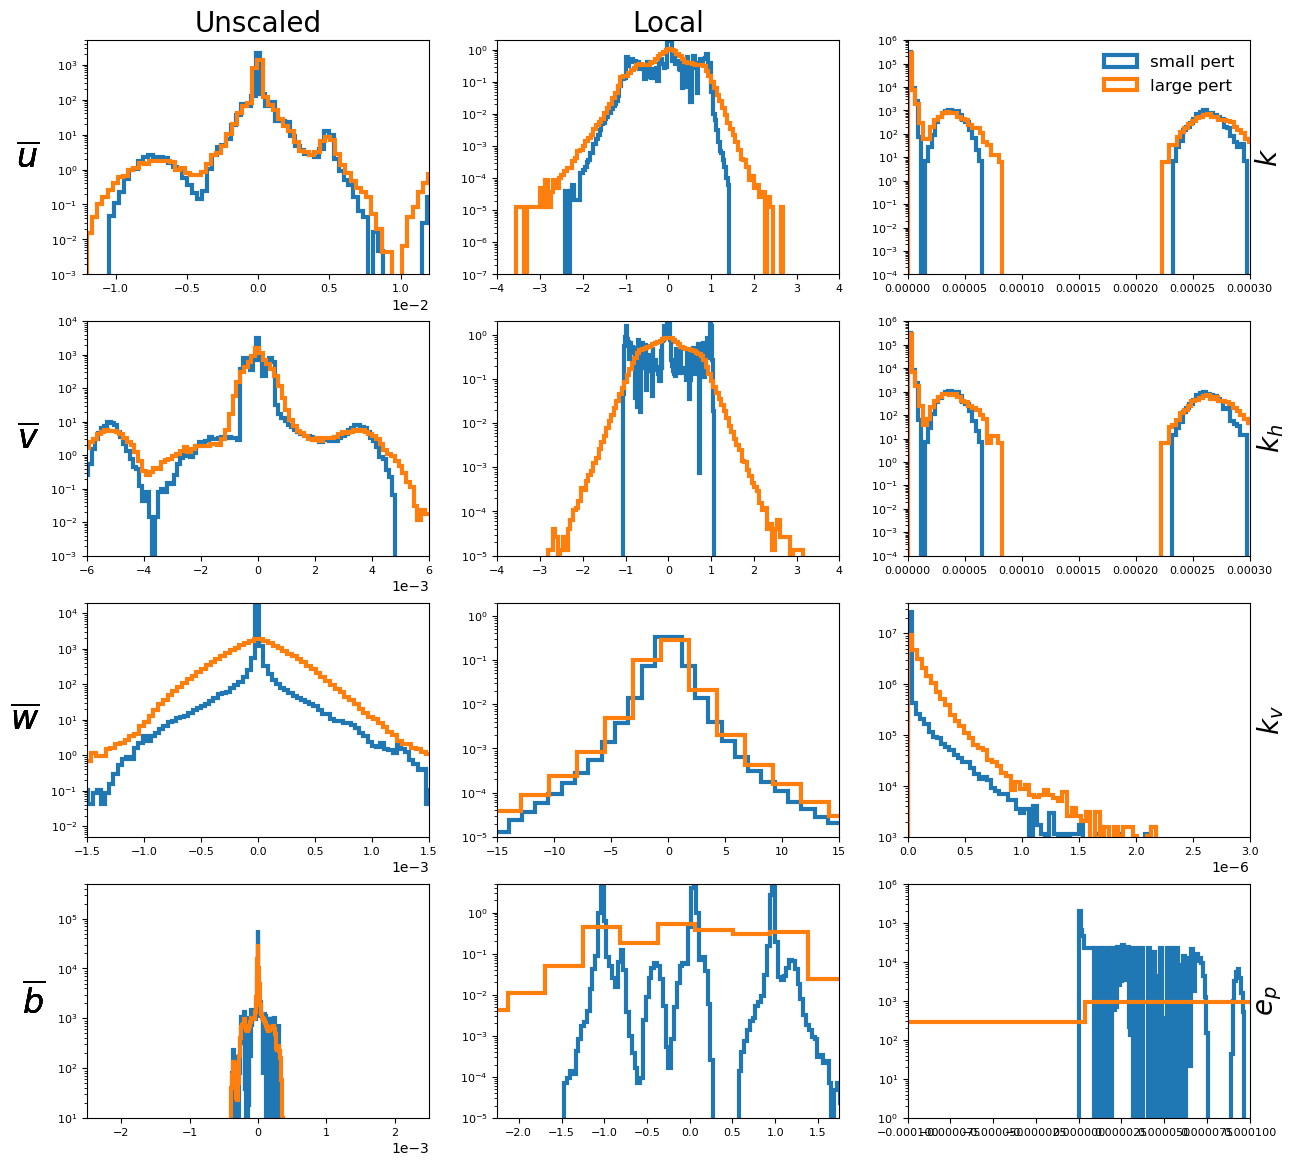

In [10]:
fs=20
ls=8
pad=0

xLims=[[[-1.2e-2,1.2e-2],[-4,4],[0,0.0003]],
       [[-6e-3,6e-3],[-4,4],[0,0.0003]],
       [[-1.5e-3,1.5e-3],[-15,15],[0,3e-6]],
       [[-2.5e-3,2.5e-3],[-2.25,1.75],[-0.0001,0.0001]]]

yLims=[[[1e-3,5e3],[1e-7,2e0],[1e-4,1e6]],
       [[1e-3,1e4],[1e-5,2e0],[1e-4,1e6]],
       [[5e-3,2e4],[1e-5,2e0],[1e3,4e7]],
       [[1e1,5e5],[1e-5,5e0],[1e0,1e6]]]

varNames = [r'$\overline{u}$', r'$\overline{v}$', r'$\overline{w}$', r'$\overline{b}$']
for ivar in range(len(varNames)):
    
    ax1[ivar,0].annotate(varNames[ivar], xy=(0, 0.5), xytext=(-ax1[ivar,0].yaxis.labelpad - pad, 0),
        xycoords=ax1[ivar,0].yaxis.label, textcoords='offset points',
        size=24, ha='right', va='center')
        
    for sc in range(3):

        ax1[ivar,sc].set_yscale('log')
        ax1[ivar,sc].set_ylabel('')
        ax1[ivar,sc].tick_params(axis='y',labelsize=ls)
        ax1[ivar,sc].tick_params(axis='x',labelsize=ls)
        ax1[ivar,sc].set_xlim(xLims[ivar][sc])
        ax1[ivar,sc].set_ylim(yLims[ivar][sc])
   
    ax1[ivar,-1].yaxis.set_label_position("right") 
    ax1[ivar,-1].set_ylabel(scaleNames[ivar],size=fs)
    ax1[ivar,0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))

ax1[0,0].set_title('Unscaled',size=fs)
#ax1[0,1].set_title('Statistical',size=fs)
#ax1[0,2].set_title('Global',size=fs)
ax1[0,1].set_title('Local',size=fs)
# handles, labels = ax1[0,-1].get_legend_handles_labels()
# new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
# ax1[0,1].legend(handles=new_handles, labels=labels)
ax1[0,-1].legend(frameon=False,framealpha=0,fontsize=12)

#plt.figure(fig1)
#fmt="png"
#plt.savefig("compareScaledInputsAll_Re."+fmt, format=fmt)

fig1

array([[[[ 6.13447491e-05,  5.66367648e-05,  5.17023280e-05],
         [ 7.22719553e-05,  6.77152509e-05,  6.15453837e-05],
         [ 6.62233594e-05,  7.05709651e-05,  7.47328131e-05],
         ...,
         [ 3.29372837e-06,  2.82574520e-06,  6.94294581e-06],
         [-1.88480927e-06, -1.27461248e-06, -1.24684556e-06],
         [-1.27039180e-06, -1.15560333e-06, -7.94199645e-07]],

        [[ 4.53033904e-05,  4.36177151e-05,  4.12348755e-05],
         [ 5.77679534e-05,  5.14552083e-05,  4.58490510e-05],
         [ 7.54547545e-05,  7.32356272e-05,  7.27653648e-05],
         ...,
         [ 1.37837221e-06,  1.61042343e-06,  1.88417387e-06],
         [ 9.33193874e-07,  1.10733857e-06,  1.15513778e-06],
         [-8.69807916e-07, -8.24396469e-07, -7.04966672e-07]],

        [[ 6.41788272e-05,  6.19547546e-05,  5.93529343e-05],
         [ 7.72139663e-05,  7.52203219e-05,  7.11645137e-05],
         [ 7.90762256e-05,  7.84484548e-05,  7.76401918e-05],
         ...,
         [ 6.41422582e-0